In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from keras.utils import to_categorical
import matplotlib.pyplot as plt


In [6]:
def ReadData():
    #importing data set(s)
    filename = 'default of credit card clients.xls'
    nanDict = {} #this does nothing with this data set
    #read file
    df = pd.read_excel(filename,header=1,skiprows=0,index_col=0,na_values=nanDict) 
    #rename last column
    df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)
    #Replace nonsensical values in PAY_i columns with 0
    for i in [0,2,3,4,5,6]:
        col = 'PAY_{}'.format(i)
        df[col].replace(to_replace=-2, value = 0, inplace=True)
    #shuffle dataset by row
    df.sample(frac=1)
    
    # Define features and targets 
    X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
    y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hots, setting nonsensical values to 0
    onehotencoder1 = OneHotEncoder(categories='auto')
    onehotencoder2 = OneHotEncoder(categories='auto',drop='first')

    # sets number of elements in onehot vectors automatically from data.
    Xt= ColumnTransformer(
        [("one", onehotencoder1, [1]),("two", onehotencoder2, [2,3]),],
        remainder="passthrough"
    ).fit_transform(X)

    # Train-test split
    trainingShare = 0.5
    seed  = 1
    XTrain, XTest, yTrain, yTest=train_test_split(Xt, y, train_size=trainingShare, \
                                                  test_size = 1-trainingShare,
                                                 random_state=seed, stratify = y)
    
    #scale data, except one-hotted
    sc = StandardScaler()
    XTrain_fitting = XTrain[:,11:]
    XTest_fitting = XTest[:,11:]
    #removes mean, scales by std
    XTrain_scaler = sc.fit_transform(XTrain_fitting)
    XTest_scaler = sc.transform(XTest_fitting)
    #puts together the complete model matrix again
    XTrain_scaled=np.c_[XTrain[:,:11],XTrain_scaler]
    XTest_scaled = np.c_[XTest[:,:11],XTest_scaler]


    
    
    return XTrain_scaled,XTest_scaled,yTrain,yTest

In [7]:
import tensorflow as tf
class NeuralNetworkTensorflow:
    def __init__(
            self,
            X_train,
            Y_train,
            X_test,
            Y_test,
#             pos_wg,
            n_neurons_layer1=100,
            n_neurons_layer2=50,
            n_categories=2,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):
        
        # keep track of number of steps
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
#         self.pos_w = pos_w
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        
        self.n_inputs = X_train.shape[0]
        self.n_features = X_train.shape[1]
        self.n_neurons_layer1 = n_neurons_layer1
        self.n_neurons_layer2 = n_neurons_layer2
        self.n_categories = n_categories
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        # build network piece by piece
        # name scopes (with) are used to enforce creation of new variables
        # https://www.tensorflow.org/guide/variables
        self.create_placeholders()
        self.create_DNN()
        self.create_loss()
        self.create_optimiser()
        self.create_accuracy()
    
    def create_placeholders(self):
        # placeholders are fine here, but "Datasets" are the preferred method
        # of streaming data into a model
        with tf.compat.v1.name_scope('data'):
#             tf.compat.v1.placeholder
            self.X = tf.compat.v1.placeholder(tf.float32, shape=(None, self.n_features), name='X_data')
            self.Y = tf.compat.v1.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
#             self.X = tf.compat.v1.placeholder(tf.float32, shape=(None, self.n_features), name='X_data')
#             self.Y = tf.compat.v1.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
    
    def create_DNN(self):
        with tf.compat.v1.name_scope('DNN'):
            # the weights are stored to calculate regularization loss later
            
            # Fully connected layer 1
            self.W_fc1 = self.weight_variable([self.n_features, self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            b_fc1 = self.bias_variable([self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            a_fc1 = tf.nn.sigmoid(tf.matmul(self.X, self.W_fc1) + b_fc1)
            
            # Fully connected layer 2
            self.W_fc2 = self.weight_variable([self.n_neurons_layer1, self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            b_fc2 = self.bias_variable([self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            a_fc2 = tf.nn.sigmoid(tf.matmul(a_fc1, self.W_fc2) + b_fc2)
            
            # Output layer
            self.W_out = self.weight_variable([self.n_neurons_layer2, self.n_categories], name='out', dtype=tf.float32)
            b_out = self.bias_variable([self.n_categories], name='out', dtype=tf.float32)
            self.z_out = tf.matmul(a_fc2, self.W_out) + b_out
    
    def create_loss(self):
        with tf.compat.v1.name_scope('loss'):
#             softmax_loss = tf.reduce_mean(input_tensor=tf.nn.weighted_cross_entropy_with_logits(labels=self.Y, logits=self.z_out,pos_weight = 0.64))
            softmax_loss = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.Y, logits=self.z_out))
            
            regularizer_loss_fc1 = tf.nn.l2_loss(self.W_fc1)
            regularizer_loss_fc2 = tf.nn.l2_loss(self.W_fc2)
            regularizer_loss_out = tf.nn.l2_loss(self.W_out)
            regularizer_loss = self.lmbd*(regularizer_loss_fc1 + regularizer_loss_fc2 + regularizer_loss_out)
            
            self.loss = softmax_loss + regularizer_loss

    def create_accuracy(self):
        with tf.compat.v1.name_scope('accuracy'):
            probabilities = tf.nn.softmax(self.z_out)
            predictions = tf.argmax(input=probabilities, axis=1)
            labels = tf.argmax(input=self.Y, axis=1)
            
            correct_predictions = tf.equal(predictions, labels)
            correct_predictions = tf.cast(correct_predictions, tf.float32)
            self.accuracy = tf.reduce_mean(input_tensor=correct_predictions)
    
    def create_optimiser(self):
        with tf.compat.v1.name_scope('optimizer'):
            self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=self.eta).minimize(self.loss, global_step=self.global_step)
            
    def weight_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.random.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def bias_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def fit(self):
        data_indices = np.arange(self.n_inputs)

        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            for i in range(self.epochs):
                for j in range(self.iterations):
                    chosen_datapoints = np.random.choice(data_indices, size=self.batch_size, replace=False)
                    batch_X, batch_Y = self.X_train[chosen_datapoints], self.Y_train[chosen_datapoints]
                    sess.run([DNN.loss, DNN.optimizer],
                        feed_dict={DNN.X: batch_X,
                                   DNN.Y: batch_Y})
                    accuracy = sess.run(DNN.accuracy,
                        feed_dict={DNN.X: batch_X,
                                   DNN.Y: batch_Y})
                    step = sess.run(DNN.global_step)
    
            self.train_loss, self.train_accuracy = sess.run([DNN.loss, DNN.accuracy],
                feed_dict={DNN.X: self.X_train,
                           DNN.Y: self.Y_train})
        
            self.test_loss, self.test_accuracy = sess.run([DNN.loss, DNN.accuracy],
                feed_dict={DNN.X: self.X_test,
                           DNN.Y: self.Y_test})

In [8]:
X_Train,X_Test,y_Train,y_Test = ReadData()
Y_train = to_categorical(y_Train)
Y_test = to_categorical(y_Test)

In [9]:
epochs = 100
batch_size = 100
n_neurons_layer1 = 100
n_neurons_layer2 = 50
n_categories = 2
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals2 = np.logspace(-5, 1, 7)
lmbd_vals = [0]
lmbd_vals = np.hstack((lmbd_vals,lmbd_vals2))
n_categories=2

In [6]:
DNN_tf = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = NeuralNetworkTensorflow(X_Train, Y_train, X_Test, Y_test,
                                      n_neurons_layer1, n_neurons_layer2, n_categories,
                                      epochs=epochs, batch_size=batch_size, eta=eta, lmbd=lmbd)
        DNN.fit()
        
        DNN_tf[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % DNN.test_accuracy)
        print("Baseline accuracy")
        print()

Learning rate =  1e-05
Lambda =  0.0
Test accuracy: 0.779
Baseline accuracy

Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 0.779
Baseline accuracy

Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.779
Baseline accuracy

Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.779
Baseline accuracy

Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.779
Baseline accuracy

Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.779
Baseline accuracy

Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.779
Baseline accuracy

Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.779
Baseline accuracy

Learning rate =  0.0001
Lambda =  0.0
Test accuracy: 0.779
Baseline accuracy

Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 0.779
Baseline accuracy

Learning rate =  0.0001
Lambda =  0.0001
Test accuracy: 0.779
Baseline accuracy

Learning rate =  0.0001
Lambda =  0.001
Test accuracy: 0.779
Baseline accuracy

Learning rate =  0.0001
Lambda =  0.01
Test accuracy: 0.

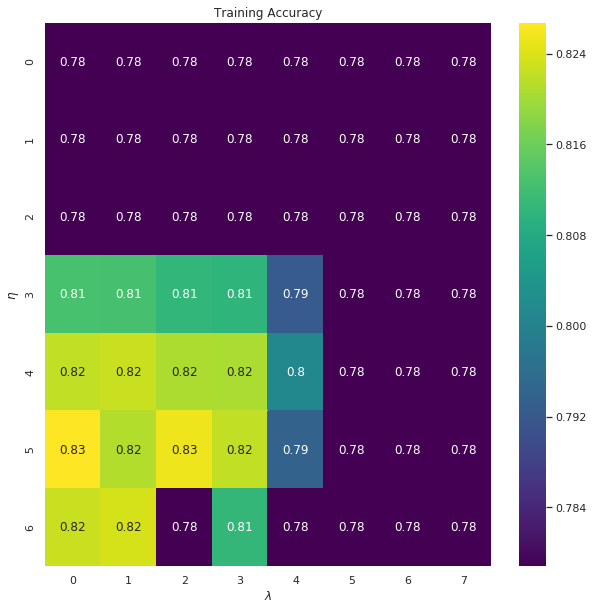

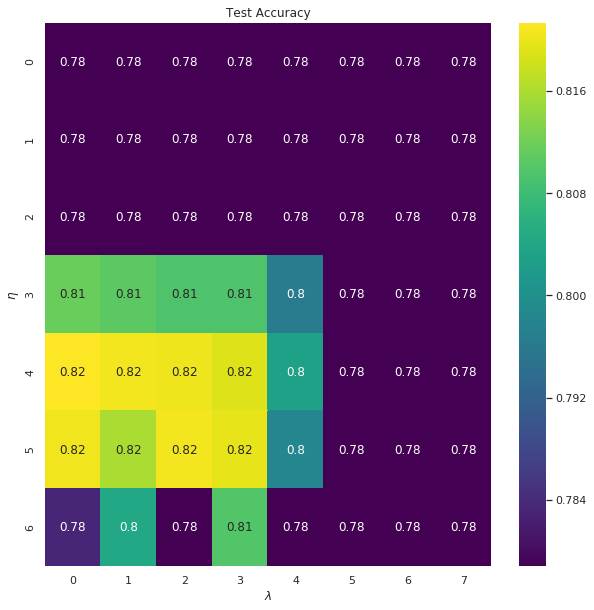

In [9]:

# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_tf[i][j]

        train_accuracy[i][j] = DNN.train_accuracy
        test_accuracy[i][j] = DNN.test_accuracy

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
first,second=ax.get_ylim()
ax.set_ylim(first+0.5,0)
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
first,second=ax.get_ylim()
ax.set_ylim(first+0.5,0)
plt.show()

# upsampling test

In [10]:
def upsample(xtrain,ytrain,class_size=11000):
    index_0=[]
    index_1=[]
    for i in range(ytrain.shape[0]):
        if ytrain[i]==0:
            index_0.append(i)
        if ytrain[i]==1:
            index_1.append(i)
    x_split_0 = xtrain[index_0,:]
    x_split_1 = xtrain[index_1,:]
    idx0 = np.random.choice(x_split_0.shape[0],size=class_size,replace=False)
    idx1 = np.random.choice(x_split_1.shape[0],size=class_size,replace=True)
    x_0 = x_split_0[idx0,:]
    x_1 = x_split_0[idx1,:]
    y = np.zeros(class_size*2)
    y[class_size:]=1
    y=y[:,np.newaxis]
    X = np.vstack((x_0,x_1))
    Xy = np.hstack((X,y))
    np.random.shuffle(Xy)
    X_upsampled=Xy[:,:xtrain.shape[1]]
    y_upsampled=Xy[:,-1]
    y_upsampled = y_upsampled[:,np.newaxis]
    return X_upsampled,y_upsampled

In [11]:
X_Train,X_Test,y_Train,y_Test = ReadData()

In [12]:
X_Train,y_Train = upsample(X_Train,y_Train)
Y_train = to_categorical(y_Train)
Y_test = to_categorical(y_Test)

In [13]:
DNN_tf = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = NeuralNetworkTensorflow(X_Train, Y_train, X_Test, Y_test,
                                      n_neurons_layer1, n_neurons_layer2, n_categories,
                                      epochs=epochs, batch_size=batch_size, eta=eta, lmbd=lmbd)
        DNN.fit()
        
        DNN_tf[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Train accuracy: %.3f" % DNN.train_accuracy)
        print("Test accuracy: %.3f" % DNN.test_accuracy)
        print("Baseline accuracy")
        print()

Learning rate =  1e-05
Lambda =  0.0
Train accuracy: 0.500
Test accuracy: 0.779
Baseline accuracy

Learning rate =  1e-05
Lambda =  1e-05
Train accuracy: 0.500
Test accuracy: 0.759
Baseline accuracy

Learning rate =  1e-05
Lambda =  0.0001
Train accuracy: 0.500
Test accuracy: 0.221
Baseline accuracy

Learning rate =  1e-05
Lambda =  0.001
Train accuracy: 0.500
Test accuracy: 0.221
Baseline accuracy

Learning rate =  1e-05
Lambda =  0.01
Train accuracy: 0.500
Test accuracy: 0.221
Baseline accuracy

Learning rate =  1e-05
Lambda =  0.1
Train accuracy: 0.500
Test accuracy: 0.779
Baseline accuracy

Learning rate =  1e-05
Lambda =  1.0
Train accuracy: 0.500
Test accuracy: 0.221
Baseline accuracy

Learning rate =  1e-05
Lambda =  10.0
Train accuracy: 0.500
Test accuracy: 0.221
Baseline accuracy

Learning rate =  0.0001
Lambda =  0.0
Train accuracy: 0.503
Test accuracy: 0.443
Baseline accuracy

Learning rate =  0.0001
Lambda =  1e-05
Train accuracy: 0.497
Test accuracy: 0.503
Baseline accurac

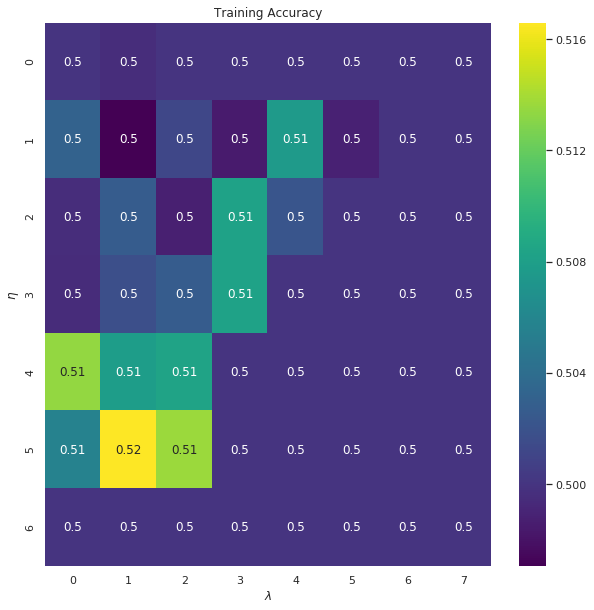

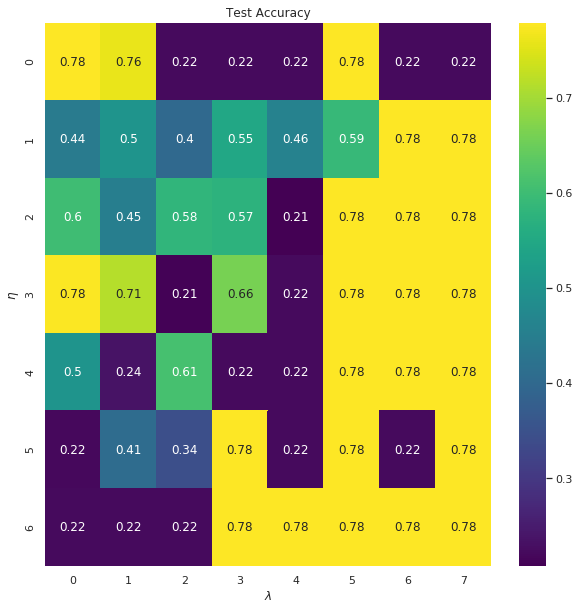

In [14]:

# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_tf[i][j]

        train_accuracy[i][j] = DNN.train_accuracy
        test_accuracy[i][j] = DNN.test_accuracy

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
first,second=ax.get_ylim()
ax.set_ylim(first+0.5,0)
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
first,second=ax.get_ylim()
ax.set_ylim(first+0.5,0)
plt.show()

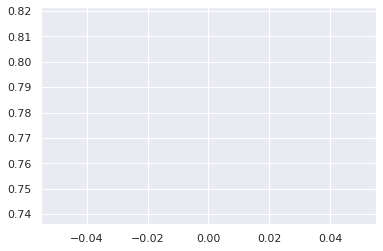

In [16]:
plt.figure()
plt.plot(DNN.test_accuracy)
plt.show()